In [2]:
import pandas as pd
from core import cli

# df_cli = cli.from_bok()
df_cli = cli.from_oecd()

In [3]:
from core.repository import maria_home

df = pd.read_sql("select * from index_chart where ticker = '1001'", maria_home())
df.index = pd.to_datetime(df["date"])
columns = {
    "종가": "idx",
    "거래대금": "amt"
}
df = df[columns.keys()]
df = df.rename(columns=columns)
df["ma100"] = df["idx"].rolling(100).mean()
df["ma200"] = df["idx"].rolling(200).mean()

df = df.resample("M").last()
df["idx_change"] = df["idx"].pct_change()
df = df.join(df_cli)
df["rtn"] = df["idx_change"].shift(-1)
df

,idx,amt,ma100,ma200,idx_change,cli_pos,cli,cli_change,rtn
date,,,,,,,,,
1975-01-31,73.53,0,NaN,NaN,NaN,NaN,NaN,NaN,0.062695
1975-02-28,78.14,0,NaN,NaN,0.062695,NaN,NaN,NaN,-0.035577
1975-03-31,75.36,0,NaN,NaN,-0.035577,NaN,NaN,NaN,-0.019374
1975-04-30,73.90,0,NaN,NaN,-0.019374,NaN,NaN,NaN,0.033559
1975-05-31,76.38,0,75.7670,NaN,0.033559,NaN,NaN,NaN,0.010867
...,...,...,...,...,...,...,...,...,...
2023-08-31,2556.27,11334960549622,2564.7146,2485.80935,-0.028987,2023-07,99.33477,0.002056,-0.035677
2023-09-30,2465.07,6761281210971,2567.1893,2496.28990,-0.035677,2023-08,99.49710,0.001634,-0.075892
2023-10-31,2277.99,8233073267951,2540.3713,2503.18640,-0.075892,2023-09,99.62574,0.001293,0.112950


In [4]:
# 1억, 1억2천

years = len(df[df["cli_change"] < 0]) / 12
(df[df["cli_change"] < 0]["rtn"] + 1).prod() ** (1 / years)

0.8606169593282139

In [5]:
import numpy as np


def make_port(arg):
    if arg["cli_change"] == np.nan:
        return np.nan
    elif arg["cli_change"] >= 0:
        return arg["rtn"]
    else:
        return -arg["rtn"]


df.loc[:, "port"] = df.apply(make_port, axis=1)

In [6]:

years = len(df["port"]) / 12
# (df[df["cli_change"] > 0]["rtn"] + 1).prod() ** (1 / years) - 1
# (df["port"] + 1).prod(), (df["port"] + 1).prod() ** (1 / years) - 1
df[["rtn", "port"]]

,rtn,port
date,,
1975-01-31,0.062695,-0.062695
1975-02-28,-0.035577,0.035577
1975-03-31,-0.019374,0.019374
1975-04-30,0.033559,-0.033559
1975-05-31,0.010867,-0.010867
...,...,...
2023-08-31,-0.035677,-0.035677
2023-09-30,-0.075892,-0.075892
2023-10-31,0.112950,0.112950


In [7]:
(df["rtn"] + 1).prod(), (df[df["cli_change"] > 0]["rtn"] + 1).prod(), (df["port"] + 1).prod()

(36.11151910784711, 40.01016362154366, 6.168291171539345)

In [8]:
(df["rtn"] + 1).prod() ** (1/7), (df["port"] + 1).prod() ** (1/7)

(1.6692478388019514, 1.2968229724358071)

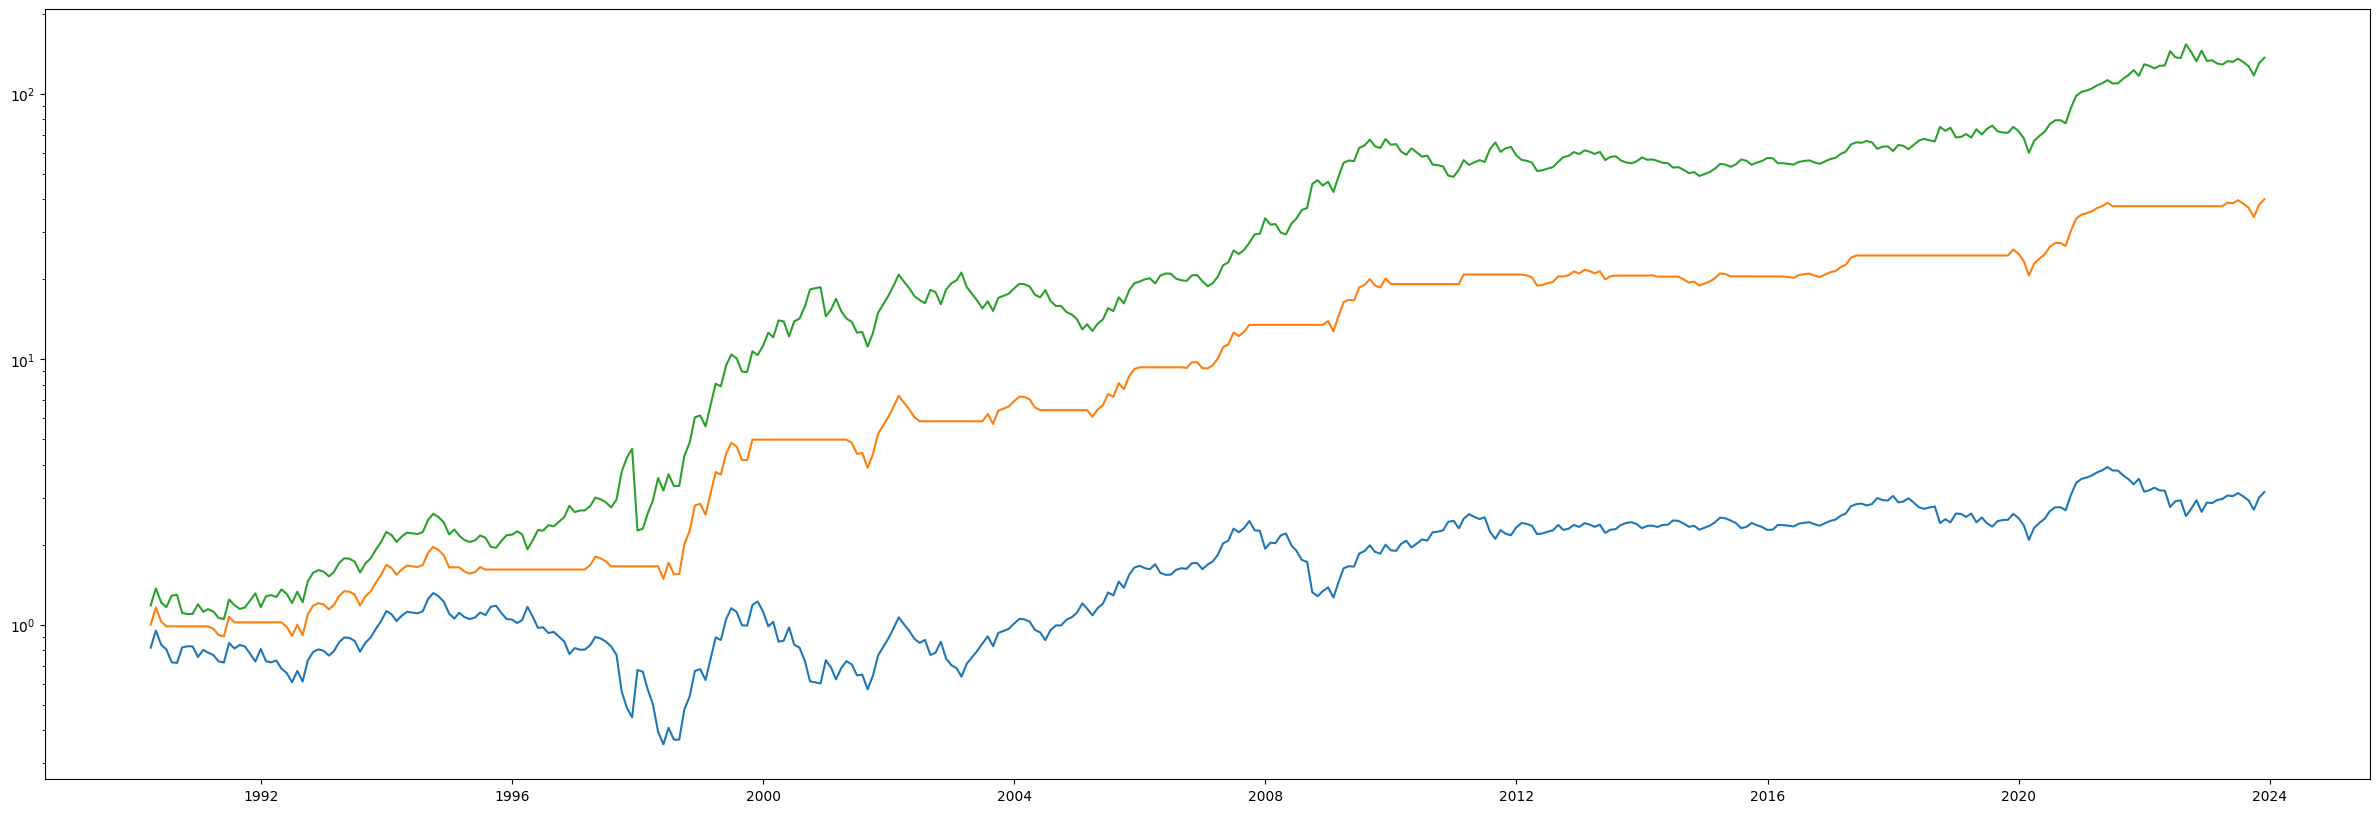

In [9]:
import matplotlib.pyplot as plt

df = df.dropna()

plt.figure(figsize=(30, 10))
plt.plot((df["rtn"] + 1).cumprod(), label="idx")
plt.plot((df[df["cli_change"] > 0]["rtn"].reindex(df.index).fillna(0) + 1).cumprod())
plt.plot((df["port"] + 1).cumprod())
plt.yscale('log')

# # 코스피지수가 ma100 보다 위에 있는 경우, 최대 높이로 색칠
# plt.fill_between(
#     df.index,
#     0, df["idx"].max(),
#     where=df["hold"],
#     facecolor="g",
#     alpha=0.1,
# )